In [1]:
# 1. 모듈 임포트

import os
import re
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW
from tqdm import tqdm
from transformers import RobertaTokenizer, RobertaForSequenceClassification, get_scheduler
import matplotlib.pyplot as plt

/opt/anaconda3/envs/practiceAI/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 2. 커스텀 Dataset 클래스 정의

class CodePairDataset(Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        if self.labels is not None:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

In [3]:
print(torch.backends.mps.is_available())      # True: 사용 가능
print(torch.backends.mps.is_built())

True
True


In [ ]:
# 3. 하이퍼 파라미터 및 디바이스 설정

device = torch.device("mps")
BATCH_SIZE = 24
NUM_EPOCHS = 15
MAX_LEN = 512

In [5]:
# # 4. 디바이스 확인

# print(torch.cuda.is_available())           # True면 GPU 사용 가능
# print(torch.cuda.get_device_name(0))       # 사용 중인 GPU 이름
# print(torch.cuda.current_device())         # 현재 선택된 디바이스 인덱스
# print(torch.cuda.device_count())           # 사용 가능한 GPU 개수
# print(torch.cuda.device(0))  

In [6]:
# 5. 데이터 불러오기 및 전처리

train_df = pd.read_csv("codebert_train.csv")
test_df = pd.read_csv("codebert_validation.csv")

def clean_code(code: str) -> str:
    # 다중행 주석 제거: '''...''' 또는 """...""" 형태의 문자열을 제거 (정규표현식 DOTALL 사용으로 줄바꿈 포함)
    code = re.sub(r'""".*?"""|\'\'\'.*?\'\'\'', '', code, flags=re.DOTALL)

    # 한 줄 주석 제거: '#'부터 라인 끝까지의 주석 제거
    code = re.sub(r'#.*', '', code)

    # 연속된 공백 문자 제거: 공백, 탭, 개행 등을 하나의 공백으로 축소
    code = re.sub(r'\s+', ' ', code)

    # 양쪽 공백 제거 후 반환
    return code.strip()

train_df['code1'] = train_df['code1'].astype(str).apply(clean_code)
train_df['code2'] = train_df['code2'].astype(str).apply(clean_code)
test_df['code1'] = test_df['code1'].astype(str).apply(clean_code)
test_df['code2'] = test_df['code2'].astype(str).apply(clean_code)

In [7]:
# transformers 경고 무시
from transformers import logging
logging.set_verbosity_error()

In [8]:
# 6. 토크나이징 및 데이터셋/로더 정의

tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")
train_encodings = tokenizer(train_df['code1'].tolist(), train_df['code2'].tolist(), truncation=True, padding=True, max_length=MAX_LEN, return_tensors="pt")
test_encodings = tokenizer(test_df['code1'].tolist(), test_df['code2'].tolist(), truncation=True, padding=True, max_length=MAX_LEN, return_tensors="pt")
train_labels = train_df["similar"].tolist()

train_dataset = CodePairDataset(train_encodings, train_labels)
test_dataset = CodePairDataset(test_encodings)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [9]:
# 7. 모델 및 옵티마이저 정의

model = RobertaForSequenceClassification.from_pretrained("microsoft/codebert-base", num_labels=2)
model.to(device)

optimizer = AdamW(model.parameters(), lr=5e-5)
loss_fn = CrossEntropyLoss()
num_training_steps = NUM_EPOCHS * len(train_loader)
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

In [10]:
# import torch
# print(torch.cuda.is_available())
# print(torch.cuda.get_device_name(0))

In [11]:
# 8. 모델 학습 루프

epoch_losses = []
model.train()

for epoch in range(NUM_EPOCHS):
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}")
    total_loss = 0
    for batch in progress_bar:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        total_loss += loss.item()
        progress_bar.set_postfix(loss=total_loss / (progress_bar.n + 1))
    avg_loss = total_loss / len(train_loader)
    epoch_losses.append(avg_loss)

Epoch 15: 100%|██████████| 625/625 [15:03<00:00,  1.45s/it, loss=0.00121] 


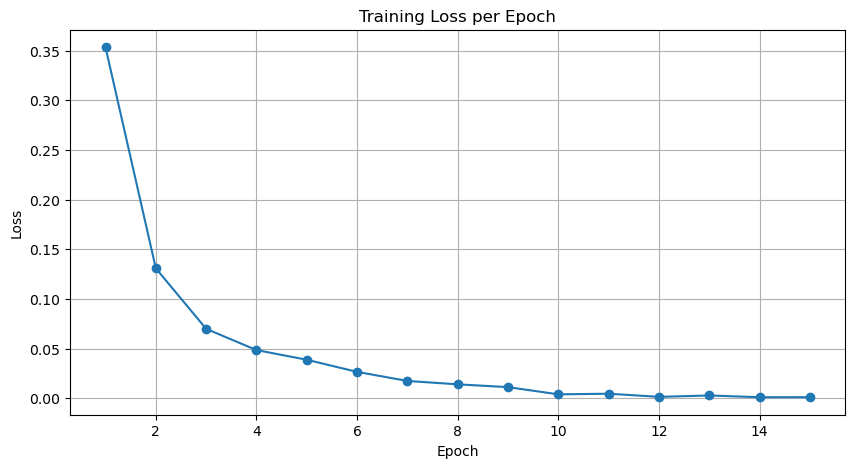

In [12]:
# 9. 모델 저장 및 시각화

torch.save(model.state_dict(), "codebert_finetuned.pt")

plt.figure(figsize=(10, 5))
plt.plot(range(1, NUM_EPOCHS + 1), epoch_losses, marker='o')
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.savefig("loss_plot.png")
plt.show()